In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from data.gp_dataloader import GPDataGenerator
from models.anp import ANPModel
from models.utils import Attention

# Set the random seed for reproducibility
torch.manual_seed(1)
np.random.seed(1)

def plot_results(target_x, target_y, context_x, context_y, pred_y, std):
  plt.plot(target_x, pred_y, linewidth=2, alpha=0.7, zorder=1, label='Predictive mean')
  plt.plot(target_x, target_y, 'k:', linewidth=1, label='Target')
  plt.scatter(context_x, context_y, c='k', zorder=2, label='Context')
  bound = std[:, 0] * 1.96
  plt.fill_between(
      target_x.squeeze(),
      pred_y[:, 0] - bound,
      pred_y[:, 0] + bound,
      alpha=0.3)
  plt.legend()
  plt.show()

cuda
Epoch: 0 Loss: 1.0148519277572632


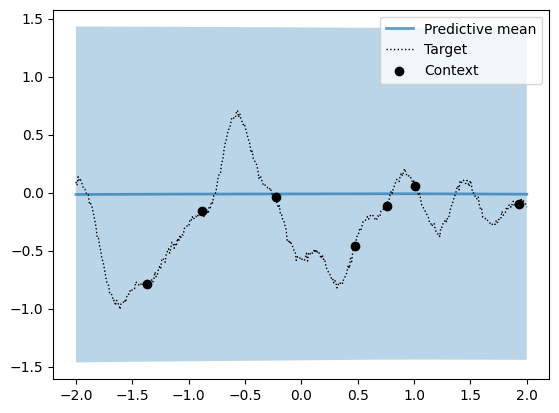

Epoch: 100 Loss: 0.9951837062835693
Epoch: 200 Loss: 0.7550837397575378
Epoch: 300 Loss: 0.4485611915588379
Epoch: 400 Loss: 0.12866680324077606
Epoch: 500 Loss: -0.030255014076828957
Epoch: 600 Loss: 0.03840436041355133
Epoch: 700 Loss: -0.08051545917987823
Epoch: 800 Loss: 0.06504779309034348
Epoch: 900 Loss: -0.27431148290634155
Epoch: 1000 Loss: 2.720863103866577


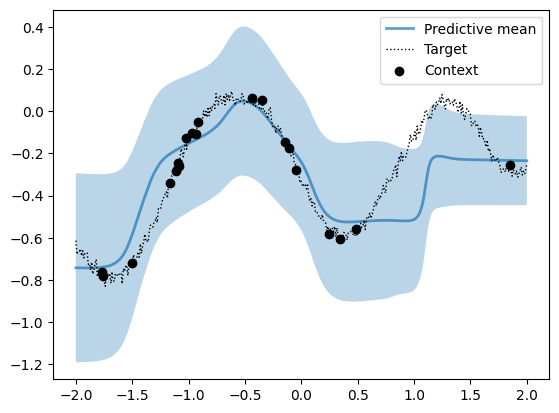

Epoch: 1100 Loss: 2.6659963130950928
Epoch: 1200 Loss: -0.28650975227355957
Epoch: 1300 Loss: -0.36992233991622925
Epoch: 1400 Loss: 4.109746932983398
Epoch: 1500 Loss: -0.39987069368362427
Epoch: 1600 Loss: -0.13188835978507996
Epoch: 1700 Loss: 0.2017049491405487
Epoch: 1800 Loss: -0.30239251255989075
Epoch: 1900 Loss: -0.1783345490694046
Epoch: 2000 Loss: -0.52329421043396


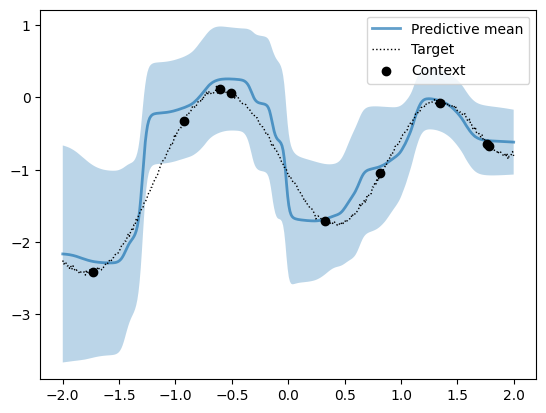

Epoch: 2100 Loss: -0.21521443128585815
Epoch: 2200 Loss: -0.5404723882675171
Epoch: 2300 Loss: -0.25138142704963684
Epoch: 2400 Loss: -0.10076986998319626
Epoch: 2500 Loss: 1.5189616680145264
Epoch: 2600 Loss: -0.15755565464496613
Epoch: 2700 Loss: -0.3086947202682495
Epoch: 2800 Loss: 0.37658432126045227
Epoch: 2900 Loss: -0.46553686261177063
Epoch: 3000 Loss: -0.3735644817352295


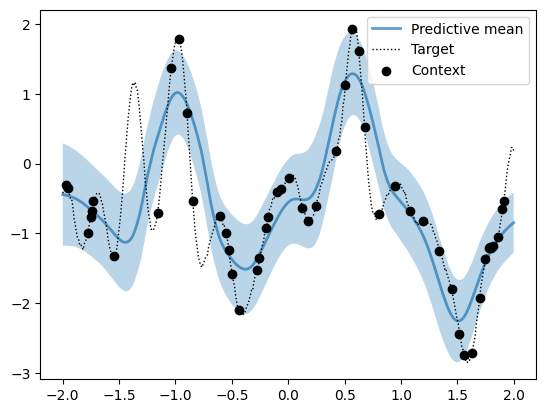

Epoch: 3100 Loss: -0.5452691316604614
Epoch: 3200 Loss: -0.5701926946640015
Epoch: 3300 Loss: -0.3472559154033661
Epoch: 3400 Loss: -0.7683119177818298
Epoch: 3500 Loss: -0.03826730698347092
Epoch: 3600 Loss: -0.45890331268310547
Epoch: 3700 Loss: -0.347057968378067
Epoch: 3800 Loss: -0.40693315863609314
Epoch: 3900 Loss: -0.6349369287490845
Epoch: 4000 Loss: -0.16948510706424713


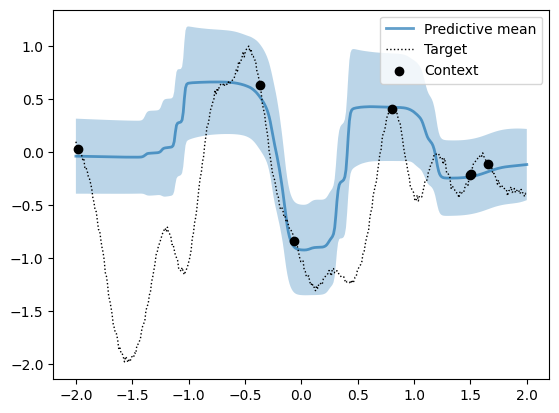

Epoch: 4100 Loss: -0.6041076183319092
Epoch: 4200 Loss: -0.20760180056095123
Epoch: 4300 Loss: -0.3070514500141144
Epoch: 4400 Loss: -0.34569892287254333
Epoch: 4500 Loss: -0.7566823363304138
Epoch: 4600 Loss: -0.4541758596897125
Epoch: 4700 Loss: 0.22669219970703125
Epoch: 4800 Loss: -0.6786185503005981
Epoch: 4900 Loss: 1.038326621055603


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_gen = GPDataGenerator(randomize_kernel_params=True, max_n_context=50)

test_gen = GPDataGenerator(randomize_kernel_params=True, testing=True, max_n_context=50, batch_size=1)

attention = Attention(attention_type="multihead", n_heads=8, embed_dim=128, scale=1.0)
model = ANPModel(x_dim=1, y_dim=1, hidden_dim=128, attention=attention)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5000):
    model.train()
    context_x, context_y, target_x, target_y = train_gen.generate_batch().get_all()
    context_x = context_x.to(device)
    context_y = context_y.to(device)
    target_x = target_x.to(device)
    target_y = target_y.to(device)

    optimizer.zero_grad()
    pred_y, std, loss, _, _ = model(context_x, context_y, target_x, target_y)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("Epoch: {} Loss: {}".format(epoch, loss.item()))

    if epoch % 1000 == 0:
        model.eval()
        context_x, context_y, target_x, target_y = test_gen.generate_batch().get_all()
        context_x = context_x.to(device)
        context_y = context_y.to(device)
        target_x = target_x.to(device)
        target_y = target_y.to(device)

        pred_y, std, loss, _, _ = model(context_x, context_y, target_x, target_y)
        plot_results(target_x.detach().cpu()[0], 
            target_y.detach().cpu()[0], 
            context_x.detach().cpu()[0], 
            context_y.detach().cpu()[0], 
            pred_y.detach().cpu()[0], 
            std.detach().cpu()[0])
        torch.save({"model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict()}, "anp_model.pt")

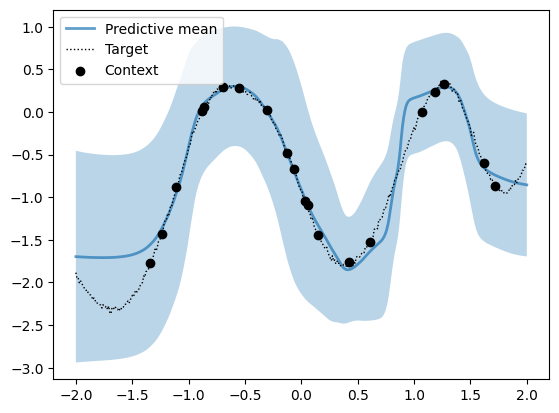

In [5]:
checkpoint = torch.load("anp_model.pt")
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

model.eval()
context_x, context_y, target_x, target_y = test_gen.generate_batch().get_all()
context_x = context_x.to(device)
context_y = context_y.to(device)
target_x = target_x.to(device)
target_y = target_y.to(device)

pred_y, std, loss, _, _ = model(context_x, context_y, target_x)
plot_results(target_x.detach().cpu()[0], 
    target_y.detach().cpu()[0], 
    context_x.detach().cpu()[0], 
    context_y.detach().cpu()[0], 
    pred_y.detach().cpu()[0], 
    std.detach().cpu()[0])